In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from dataset.dataloader import SHREC22_data
from contrastive.moco import MoCo
from augmentations.augmentations import augmentations_sequence1, augmentations_sequence2
from encoders.encoders import STGCN_model
#from classification.classification import SSL_model

In [2]:
# Reproducibility
seed = 42
random.seed(seed)                
np.random.seed(seed)             
torch.manual_seed(seed)         
torch.cuda.manual_seed(seed)     
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# load datasets
train_path = './dataset/training_set/training_set/'
test_path = './dataset/training_set/test_set/'

T = 90  # Sequence length for loading
trainset = SHREC22_data(train_path, T)
len(trainset)

576

In [5]:
# Extract labels and indices
labels = [data['Label'] for data in trainset]
indices = list(range(len(trainset)))

# train validation split
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2,    
    stratify=labels,  
    random_state=seed   
)

# Create subsets for training and validation
train_set = Subset(trainset, train_indices)
val_set = Subset(trainset, val_indices)

print('Train set size:',len(train_set))
print('Validation set size:',len(val_set))


Train set size: 460
Validation set size: 116


### Self-supervised learning

In [6]:
# Hyperparameters for self-supervised training
batch_size = 64
learning_rate = 1e-3
queue_size = 256
graph_args = {
    'strategy': 'spatial',
    'max_hop': 1,
    'dilation': 1
}

momentum = 0.999 # momentum
temperature = 0.07 # temperature

In [7]:
# Data loader for self-supervised without labels
trainloader_ssl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader_ssl = DataLoader(val_set, batch_size=batch_size, shuffle=True)
# Data augmentation
augmentations1 = augmentations_sequence1()
#augmentations2 = augmentations_sequence2()

# Load base encoder for MoCo
base_encoder = STGCN_model(in_channels=3, 
                           hidden_channels=16, 
                           hidden_dim=64, out_dim=128, 
                           graph_args=graph_args, 
                           edge_importance_weighting=True,
                           dropout_rate=0).to(device)

# Load MoCo Model
moco_model = MoCo(base_encoder=base_encoder, 
                  dim = 128, 
                  K=queue_size, 
                  m=momentum, 
                  T=temperature,
                  mlp=False).to(device)

In [8]:
n_epochs = 2000

### Self-supervised training with InfoNCE loss
optimizer = optim.Adam(moco_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_loss, val_loss = [], []
for epoch in tqdm(range(n_epochs)):
    # Training
    moco_model.train()
    total_train_loss = 0.0
    for batch in trainloader_ssl:
        seqs = batch['Sequence'].float().to(device)
        seqs_aug1 = augmentations1(seqs)
        seqs_aug2 = augmentations1(seqs)
        optimizer.zero_grad()

        # Forward pass
        logits, labels = moco_model(seqs_aug1, seqs_aug2, training=True)
        loss = loss_fn(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    train_loss.append(total_train_loss/len(trainloader_ssl))

    # Validation
    moco_model.eval()
    total_val_loss = 0.0

    with torch.no_grad(): 
        for batch in valloader_ssl:
            seqs = batch['Sequence'].float().to(device)
            seqs_aug1 = augmentations1(seqs)
            seqs_aug2 = augmentations1(seqs)
            
            # Forward pass
            logits, labels = moco_model(seqs_aug1, seqs_aug2, training=False)
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()

    val_loss.append(total_val_loss/len(valloader_ssl))
  
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train Loss: {train_loss[-1]:.4f}")
        print(f"  Val Loss: {val_loss[-1]:.4f}")


  5%|▌         | 100/2000 [01:47<33:45,  1.07s/it]

Epoch [100/2000]
  Train Loss: 4.9941
  Val Loss: 4.9407


 10%|█         | 200/2000 [03:35<32:23,  1.08s/it]

Epoch [200/2000]
  Train Loss: 4.6272
  Val Loss: 4.5178


 15%|█▌        | 300/2000 [05:22<29:59,  1.06s/it]

Epoch [300/2000]
  Train Loss: 4.0361
  Val Loss: 3.8444


 20%|██        | 400/2000 [07:09<29:22,  1.10s/it]

Epoch [400/2000]
  Train Loss: 3.4930
  Val Loss: 3.5188


 25%|██▌       | 500/2000 [08:57<26:31,  1.06s/it]

Epoch [500/2000]
  Train Loss: 3.2176
  Val Loss: 3.0791


 30%|███       | 600/2000 [10:43<25:20,  1.09s/it]

Epoch [600/2000]
  Train Loss: 2.7483
  Val Loss: 3.2366


 35%|███▌      | 700/2000 [12:31<22:51,  1.06s/it]

Epoch [700/2000]
  Train Loss: 2.6999
  Val Loss: 2.6378


 40%|████      | 800/2000 [14:17<21:17,  1.06s/it]

Epoch [800/2000]
  Train Loss: 2.7063
  Val Loss: 2.7705


 45%|████▌     | 900/2000 [16:06<19:44,  1.08s/it]

Epoch [900/2000]
  Train Loss: 2.3839
  Val Loss: 2.6043


 50%|█████     | 1000/2000 [17:52<17:37,  1.06s/it]

Epoch [1000/2000]
  Train Loss: 2.2668
  Val Loss: 2.6845


 55%|█████▌    | 1100/2000 [19:39<16:12,  1.08s/it]

Epoch [1100/2000]
  Train Loss: 2.1318
  Val Loss: 2.3803


 60%|██████    | 1200/2000 [21:26<14:06,  1.06s/it]

Epoch [1200/2000]
  Train Loss: 2.0718
  Val Loss: 1.8260


 65%|██████▌   | 1300/2000 [23:13<12:35,  1.08s/it]

Epoch [1300/2000]
  Train Loss: 2.0948
  Val Loss: 2.0177


 70%|███████   | 1400/2000 [25:00<10:28,  1.05s/it]

Epoch [1400/2000]
  Train Loss: 2.3131
  Val Loss: 2.2238


 75%|███████▌  | 1500/2000 [26:47<09:06,  1.09s/it]

Epoch [1500/2000]
  Train Loss: 2.1472
  Val Loss: 1.5641


 80%|████████  | 1600/2000 [28:35<07:01,  1.05s/it]

Epoch [1600/2000]
  Train Loss: 2.1442
  Val Loss: 1.7802


 85%|████████▌ | 1700/2000 [30:21<05:24,  1.08s/it]

Epoch [1700/2000]
  Train Loss: 2.1173
  Val Loss: 1.7316


 90%|█████████ | 1800/2000 [32:09<03:35,  1.08s/it]

Epoch [1800/2000]
  Train Loss: 1.7790
  Val Loss: 2.0502


 95%|█████████▌| 1900/2000 [33:55<01:45,  1.05s/it]

Epoch [1900/2000]
  Train Loss: 1.6488
  Val Loss: 1.8189


100%|██████████| 2000/2000 [35:43<00:00,  1.07s/it]

Epoch [2000/2000]
  Train Loss: 1.6167
  Val Loss: 1.7634


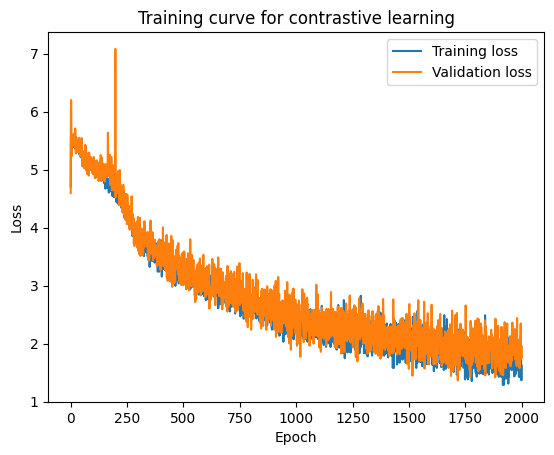

In [11]:
# Plot training curve
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training curve for contrastive learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Save the query encoder for downstream task
torch.save(moco_model.encoder_q.state_dict(), 'encoder_q256.pth')

### Downstream Classification

In [21]:
""" # load the trained query encoder
graph_args = {
    'strategy': 'spatial',
    'max_hop': 1,
    'dilation': 1
}
encoder_q = STGCN_model(in_channels=3, 
                           hidden_channels=16, 
                           hidden_dim=64, out_dim=128, 
                           graph_args=graph_args, 
                           edge_importance_weighting=True,
                           dropout_rate=0).to(device)
encoder_q.load_state_dict(torch.load("encoder_q256.pth")) """

C:\Users\Asus\AppData\Local\Temp\ipykernel_9336\3634928539.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_q.load_state_dict(torch.load("encoder_q.pth"))


<All keys matched successfully>

In [13]:
# Take out a proportion of data for downstream classification 
classify_ratio = 0.5  # the proportion of the training set to use for downstream classification
indices = list(range(len(train_set)))
train_labels = [data['Label'] for data in train_set] 
classify_indices, _ = train_test_split(
    indices, 
    test_size=1 - classify_ratio,  
    stratify=train_labels,          
    random_state=seed               
)

classify_set = Subset(train_set, classify_indices)
len(classify_set)

230

In [14]:
# classifier
trainloader_classify = DataLoader(classify_set, batch_size=64, shuffle=True)
valloader_classify = DataLoader(val_set, batch_size=64, shuffle=True)

In [18]:
class Classifier(nn.Module):
    def __init__(self, hidden_dim, num_classes = 16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.classifier = nn.Linear(self.hidden_dim, self.num_classes)
    
    def forward(self,x):
        logits = self.classifier(x)
        return logits
    
classifier = Classifier(hidden_dim=128, num_classes=16).to(device)

In [19]:
for param in moco_model.encoder_q.parameters():
    param.requires_grad = False
# Training downstream classifier
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

train_loss, train_acc = [], []
val_loss, val_acc = [], []
n_epochs = 200
for epoch in tqdm(range(n_epochs)):
    classifier.train()
    moco_model.encoder_q.eval()

    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in trainloader_classify:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)
        
        optimizer.zero_grad()

        # Forward pass
        with torch.no_grad():
            feature = moco_model.encoder_q(seqs)
        
        output = classifier(feature)
        loss = loss_fn(output, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss.append(total_train_loss / len(trainloader_classify))
    train_acc.append(correct_train / total_train)

    # Validation
    classifier.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): 
        for batch in valloader_classify:
            seqs = batch['Sequence'].float().to(device)
            labels = batch['Label'].to(device)

            # Forward pass
            feature = moco_model.encoder_q(seqs)
            output = classifier(feature)
            loss = loss_fn(output, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss.append(total_val_loss / len(valloader_classify))
    val_acc.append(correct_val / total_val)
  
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}")
        print(f"  Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}")


  6%|▌         | 11/200 [00:01<00:21,  8.91it/s]

Epoch [10/200]
  Train Loss: 1.9429, Train Accuracy: 0.6391
  Val Loss: 2.0212, Val Accuracy: 0.5086


 10%|█         | 21/200 [00:02<00:19,  9.02it/s]

Epoch [20/200]
  Train Loss: 1.4263, Train Accuracy: 0.7957
  Val Loss: 1.6131, Val Accuracy: 0.6552


 16%|█▌        | 31/200 [00:03<00:18,  9.38it/s]

Epoch [30/200]
  Train Loss: 1.1325, Train Accuracy: 0.8348
  Val Loss: 1.3755, Val Accuracy: 0.6810


 20%|██        | 41/200 [00:04<00:16,  9.56it/s]

Epoch [40/200]
  Train Loss: 0.9666, Train Accuracy: 0.8391
  Val Loss: 1.2300, Val Accuracy: 0.6810


 26%|██▌       | 51/200 [00:05<00:15,  9.52it/s]

Epoch [50/200]
  Train Loss: 0.8269, Train Accuracy: 0.8391
  Val Loss: 1.1350, Val Accuracy: 0.6897


 30%|███       | 61/200 [00:06<00:14,  9.50it/s]

Epoch [60/200]
  Train Loss: 0.7497, Train Accuracy: 0.8435
  Val Loss: 1.0826, Val Accuracy: 0.6897


 36%|███▌      | 71/200 [00:07<00:13,  9.62it/s]

Epoch [70/200]
  Train Loss: 0.6707, Train Accuracy: 0.8522
  Val Loss: 1.0186, Val Accuracy: 0.6983


 40%|████      | 81/200 [00:08<00:12,  9.54it/s]

Epoch [80/200]
  Train Loss: 0.6236, Train Accuracy: 0.8652
  Val Loss: 1.0003, Val Accuracy: 0.6983


 46%|████▌     | 91/200 [00:09<00:11,  9.65it/s]

Epoch [90/200]
  Train Loss: 0.5797, Train Accuracy: 0.8783
  Val Loss: 0.9682, Val Accuracy: 0.6983


 50%|█████     | 101/200 [00:10<00:10,  9.60it/s]

Epoch [100/200]
  Train Loss: 0.5559, Train Accuracy: 0.8739
  Val Loss: 0.9539, Val Accuracy: 0.6897


 56%|█████▌    | 111/200 [00:12<00:09,  9.40it/s]

Epoch [110/200]
  Train Loss: 0.5087, Train Accuracy: 0.8696
  Val Loss: 0.9294, Val Accuracy: 0.6810


 60%|██████    | 121/200 [00:13<00:08,  9.40it/s]

Epoch [120/200]
  Train Loss: 0.4893, Train Accuracy: 0.8826
  Val Loss: 0.9122, Val Accuracy: 0.6810


 66%|██████▌   | 131/200 [00:14<00:07,  9.37it/s]

Epoch [130/200]
  Train Loss: 0.4726, Train Accuracy: 0.8826
  Val Loss: 0.9230, Val Accuracy: 0.6810


 70%|███████   | 141/200 [00:15<00:06,  9.21it/s]

Epoch [140/200]
  Train Loss: 0.4532, Train Accuracy: 0.8913
  Val Loss: 0.8974, Val Accuracy: 0.6897


 76%|███████▌  | 151/200 [00:16<00:05,  9.37it/s]

Epoch [150/200]
  Train Loss: 0.4339, Train Accuracy: 0.9000
  Val Loss: 0.9104, Val Accuracy: 0.6724


 80%|████████  | 161/200 [00:17<00:04,  9.46it/s]

Epoch [160/200]
  Train Loss: 0.4242, Train Accuracy: 0.8957
  Val Loss: 0.9124, Val Accuracy: 0.6724


 86%|████████▌ | 171/200 [00:18<00:03,  9.52it/s]

Epoch [170/200]
  Train Loss: 0.3959, Train Accuracy: 0.8957
  Val Loss: 0.9351, Val Accuracy: 0.6724


 90%|█████████ | 181/200 [00:19<00:01,  9.59it/s]

Epoch [180/200]
  Train Loss: 0.3902, Train Accuracy: 0.9000
  Val Loss: 0.8818, Val Accuracy: 0.6724


 96%|█████████▌| 192/200 [00:20<00:00,  9.58it/s]

Epoch [190/200]
  Train Loss: 0.3810, Train Accuracy: 0.9087
  Val Loss: 0.8934, Val Accuracy: 0.6724


100%|██████████| 200/200 [00:21<00:00,  9.30it/s]

Epoch [200/200]
  Train Loss: 0.3643, Train Accuracy: 0.9043
  Val Loss: 0.9048, Val Accuracy: 0.6724


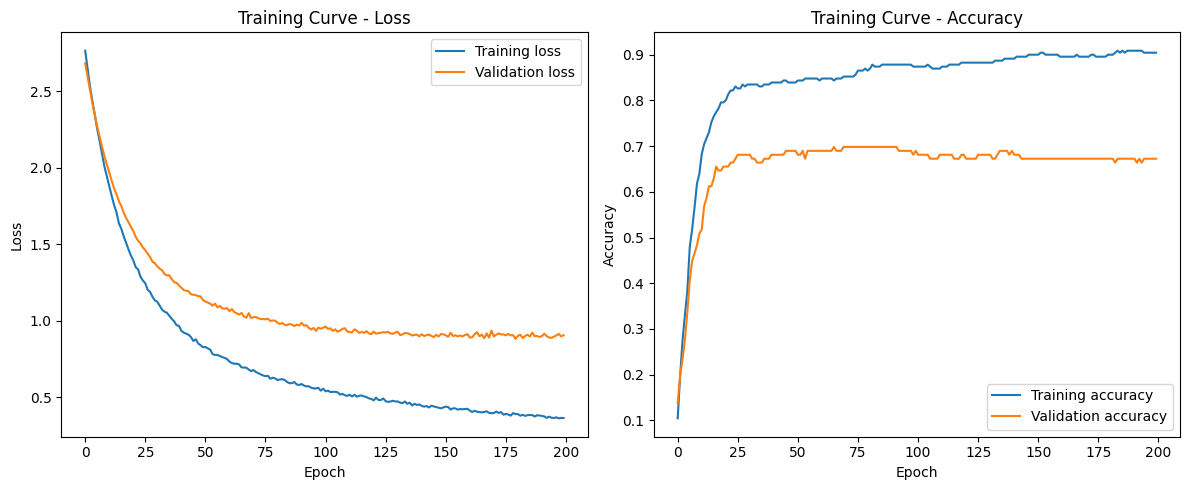

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

# Plot loss
axes[0].plot(train_loss, label='Training loss')
axes[0].plot(val_loss, label='Validation loss')
axes[0].set_title('Training Curve - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(train_acc, label='Training accuracy')
axes[1].plot(val_acc, label='Validation accuracy')
axes[1].set_title('Training Curve - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()